# Next work: add image description to metadata and generate new embeddings

In [16]:
!pip install -q langchain langchain_experimental  python-dotenv -qU langchain-google-genai pytubefix opencv-python  youtube-transcript-api webvtt-py lancedb faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.0/209.0 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.5 MB/s eta 0:00:00


In [22]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [3]:
import faiss
import numpy as np
from pytubefix import YouTube
import os,glob
import os
import cv2
import json
from youtube_transcript_api import YouTubeTranscriptApi
from youtube_transcript_api.formatters import WebVTTFormatter
import base64
import PIL
from PIL import Image
# from PIL import Image
from io import BytesIO

def download_video(video_url, path='videos'):
    print(f'Getting video information for {video_url}')

    if not video_url.startswith('http'):
        return os.path.join(path, video_url)
    filepath = glob.glob(os.path.join(path, '*.mp4'))
    print(filepath)
    if len(filepath) > 0:
        print(2)
        return filepath[0]
    print(1)
    yt = YouTube(video_url)
    stream = yt.streams.filter(progressive=True, file_extension='mp4', res='720p').desc().first()
    if stream is None:
        stream = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
    if not os.path.exists(path):
        os.makedirs(path)
    filepath = os.path.join(path, stream.default_filename)
    if not os.path.exists(filepath):
        print('Downloading video from YouTube...')
        stream.download(path)
        print(path)

    return filepath

def load_json_file(file_path):
    # Open the JSON file in read mode
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def get_video_id_from_url(video_url):
    """
    Examples:
    - http://youtu.be/SA2iWivDJiE
    - http://www.youtube.com/watch?v=_oPAwA_Udwc&feature=feedu
    - http://www.youtube.com/embed/SA2iWivDJiE
    - http://www.youtube.com/v/SA2iWivDJiE?version=3&amp;hl=en_US
    """
    import urllib.parse
    url = urllib.parse.urlparse(video_url)
    if url.hostname == 'youtu.be':
        return url.path[1:]
    if url.hostname in ('www.youtube.com', 'youtube.com'):
        if url.path == '/watch':
            p = urllib.parse.parse_qs(url.query)
            return p['v'][0]
        if url.path[:7] == '/embed/':
            return url.path.split('/')[2]
        if url.path[:3] == '/v/':
            return url.path.split('/')[2]
        return video_url



def get_transcript_vtt(video_url, path='videos'):
    video_id = get_video_id_from_url(video_url)
    filepath = os.path.join(path,'captions.vtt')
    if os.path.exists(filepath):
        return filepath

    transcript = YouTubeTranscriptApi.get_transcript(video_id, languages=['en-GB', 'en'])
    formatter = WebVTTFormatter()
    webvtt_formatted = formatter.format_transcript(transcript)

    with open(filepath, 'w', encoding='utf-8') as webvtt_file:
        webvtt_file.write(webvtt_formatted)
    webvtt_file.close()

    return filepath



def str2time(strtime):
    # strip character " if exists
    strtime = strtime.strip('"')
    # get hour, minute, second from time string
    hrs, mins, seconds = [float(c) for c in strtime.split(':')]
    # get the corresponding time as total seconds
    total_seconds = hrs * 60**2 + mins * 60 + seconds
    total_miliseconds = total_seconds * 1000
    return total_miliseconds

def maintain_aspect_ratio_resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # Grab the image size and initialize dimensions
    dim = None
    (h, w) = image.shape[:2]

    # Return original image if no need to resize
    if width is None and height is None:
        return image

    # We are resizing height if width is none
    if width is None:
        # Calculate the ratio of the height and construct the dimensions
        r = height / float(h)
        dim = (int(w * r), height)
    # We are resizing width if height is none
    else:
        # Calculate the ratio of the width and construct the dimensions
        r = width / float(w)
        dim = (width, int(h * r))
    return cv2.resize(image, dim, interpolation=inter)


def encode_image(image_path_or_PIL_img):
    if isinstance(image_path_or_PIL_img, PIL.Image.Image):
        # this is a PIL image
        buffered = BytesIO()
        image_path_or_PIL_img.save(buffered, format="JPEG")
        return base64.b64encode(buffered.getvalue()).decode('utf-8')
    else:
        # this is a image_path
        with open(image_path_or_PIL_img, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')


In [122]:
'''
1. A frame right at the middle of the time frame of the video segment;
2. Its metadata including:
-extracted_frame_path: Path to the saved extracted-frame;
-transcript: Transcript of the extracted frame;
-video_segment_id: The order of video segment from which the frame
was extracted;
-video_path: Path to the video from which the frame was extracted;
This helps to retrieve the correct video when there are many ones
in your video corpus;
-mid_time_ms: Time stamp (in ms) of the extracted frame

'''

import os.path as osp
import cv2
import webvtt
import json
import time
def extract_and_save_frames_and_metadata(
        path_to_video,
        path_to_transcript,
        path_to_save_extracted_frames,
        path_to_save_metadatas):

    # metadatas will store the metadata of all extracted frames
    metadatas = []

    # load video using cv2
    video = cv2.VideoCapture(path_to_video)
    # load transcript using webvtt
    trans = webvtt.read(path_to_transcript)

    # iterate transcript file
    # for each video segment specified in the transcript file
    for idx, transcript in enumerate(trans):
        # get the start time and end time in seconds
        start_time_ms = str2time(transcript.start)
        end_time_ms = str2time(transcript.end)
        # get the time in ms exactly
        # in the middle of start time and end time
        mid_time_ms = (end_time_ms + start_time_ms) / 2
        # get the transcript, remove the next-line symbol
        text = ''
        if idx > 2:
            for x in range(2,-1,-1):
                text += trans[idx-x].text.replace("\n", ' ')
        text = transcript.text.replace("\n", ' ')
        if idx+3 < len(trans):
            for x in range(3):
                text += trans[idx+x].text.replace("\n", ' ')
        # get frame at the middle time
        video.set(cv2.CAP_PROP_POS_MSEC, mid_time_ms)
        success, frame = video.read()
        if success:
            # if the frame is extracted successfully, resize it
            image = maintain_aspect_ratio_resize(frame, height=350)
            # save frame as JPEG file

            img_fname = f'frame_{idx}.jpg'
            img_fpath = osp.join(
                path_to_save_extracted_frames, img_fname
            )
            cv2.imwrite(img_fpath, image)

            # prepare the metadata
            metadata = {
                'extracted_frame_path': img_fpath,
                'transcript': text,
                'video_segment_id': idx,
                'video_path': path_to_video,
                'mid_time_ms': mid_time_ms,
            }
            metadatas.append(metadata)

        else:
            print(f"ERROR! Cannot extract frame: idx = {idx}")

    # save metadata of all extracted frames
    fn = osp.join(path_to_save_metadatas, 'metadatas.json')
    with open(fn, 'w') as outfile:
        json.dump(metadatas, outfile)
    return metadatas

In [91]:
v_path = download_video('https://www.youtube.com/watch?v=bgxhq2iP1Sc')
t_path = get_transcript_vtt('https://www.youtube.com/watch?v=bgxhq2iP1Sc')

Getting video information for https://www.youtube.com/watch?v=bgxhq2iP1Sc
['videos/Google Computer Solves Septillion-Year Task in Minutes.mp4']
2


In [123]:
newpath = r'/content/videos/frames2'
if not os.path.exists(newpath):
    os.makedirs(newpath)
extract_and_save_frames_and_metadata('/content/videos/Google Computer Solves Septillion-Year Task in Minutes.mp4','/content/videos/captions.vtt','/content/videos/frames2','videos')

[{'extracted_frame_path': '/content/videos/frames2/frame_0.jpg',
  'transcript': 'The biggest challenge thus far has been ultimately error correction.The biggest challenge thus far has been ultimately error correction.Can you just talk us through what you have just achieved?Yeah. The biggest news for today is that we',
  'video_segment_id': 0,
  'video_path': '/content/videos/Google Computer Solves Septillion-Year Task in Minutes.mp4',
  'mid_time_ms': 2370.0},
 {'extracted_frame_path': '/content/videos/frames2/frame_1.jpg',
  'transcript': 'Can you just talk us through what you have just achieved?Can you just talk us through what you have just achieved?Yeah. The biggest news for today is that wedeveloped the new very high quality quantum chip, and this enabled two',
  'video_segment_id': 1,
  'video_path': '/content/videos/Google Computer Solves Septillion-Year Task in Minutes.mp4',
  'mid_time_ms': 5715.0},
 {'extracted_frame_path': '/content/videos/frames2/frame_2.jpg',
  'transcrip

In [8]:
!pip install faiss-cpu

In [93]:
# Import pytorch
import torch
# Import transformers to load the model and processor from Hugging Face
from transformers import CLIPProcessor, CLIPModel

# Load the CLIP model from Hugging Face
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
# Load the processor used to pre-process the images and make them compatible with the model
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def normalize_embeddings(embeddings):
    return embeddings / embeddings.norm(dim=-1, keepdim=True)

# Define the method
def create_embeddings(image=None, text=None):
    # Initialize embeddings
    image_embeddings = None
    text_embeddings = None

    # Process the image if provided
    if image is not None:
        image = processor(images=image, return_tensors="pt", padding=True).pixel_values
        image_embeddings = model.get_image_features(image)
        image_embeddings = torch.tensor(image_embeddings)
        image_embeddings = normalize_embeddings(image_embeddings)

    # Process the text if provided
    if text is not None:
        text_inputs = processor(text=[text], return_tensors="pt", padding=True)
        with torch.no_grad():
            text_outputs = model.get_text_features(**text_inputs)
            text_embeddings = normalize_embeddings(text_outputs)
            text_embeddings = text_embeddings.squeeze(0).tolist()

    # Combine the embeddings if both image and text are provided, and normalize
    if image_embeddings is not None and text_embeddings is not None:
        combined_embeddings = (image_embeddings + torch.tensor(text_embeddings)) / 2
        combined_embeddings = normalize_embeddings(combined_embeddings)
        return combined_embeddings.tolist()

    # Return only image or text embeddings if one of them is provided
    return image_embeddings.tolist() if text_embeddings is None else text_embeddings

In [125]:
def load_json_file(file_path):
    # Open the JSON file in read mode
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data
def generate_embeddings(vector_db,data,llm):
  id_to_metadata = {}
  for i,item in enumerate(data):
    if i%10 == 0:
        time.sleep(10)
    image = Image.open(item['extracted_frame_path']).convert('RGB')
    text = item['transcript']
    image_desc = get_description(item['extracted_frame_path'],llm)
    if isinstance(data, dict):
        item['image_description'] = image_desc['image_description']
        item['contextual_information'] = image_desc['contextual_information']
        if image_desc['entities']['persons']:
          item['persons'] = image_desc['entities']['persons']
        if image_desc['entities']['organizations']:
          item['organizations'] = image_desc['entities']['organizations']
        if image_desc['entities']['locations']:
          item['locations'] = image_desc['entities']['locations']
        if image_desc['entities']['dates']:
          item['dates'] = image_desc['entities']['dates']

    embed = create_embeddings(image,text)[0]

    vector_db.add(np.array([embed], dtype=np.float32))
    id_to_metadata[len(id_to_metadata)] = item
  return id_to_metadata


In [77]:
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
import base64, httpx
from PIL import Image
from io import BytesIO
def get_description(image_path,lmm):
    # Initialize the model

    # Download and encode the image
    # Download and encode the image
    image = Image.open(image_path).convert('RGB')

    # Convert the image to bytes
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    image_data = base64.b64encode(buffered.getvalue()).decode("utf-8")


    # Create a message with the image
    message = HumanMessage(
        content=[
            {"type": "text", "text": " JSON only You are an expert AI assistant capable of extracting information from images. Please follow the steps below:Content Extraction: Analyze the given image and extract all visible text (OCR).Named Entity Recognition (NER): Identify entities within the extracted text, categorized into the following: Persons: Names of individuals.Organizations: Companies, institutions, or groups.Locations: Cities, countries, landmarks, or addresses.Dates: Any date or time-related information.Numbers: Numerical values such as amounts, percentages, etc and for description and context give important tokens only .Provide the output in the following structured JSON format  give tokens only not sentenses that precisly descirbe for context and description Use this JSON schema no next line tags: { 'extracted_text': '<All text extracted from the image>', 'entities': { 'persons': ['<List of identified persons>'], 'organizations': ['<List of identified organizations>'], 'locations': ['<List of identified locations>'], 'dates': ['<List of identified dates>'], 'numbers': ['<List of identified numbers>'] },'image_description': 'tokens that describe  the scene and objects.','contextual_information': 'tokens that give Interpretation of the images purpose or intent.'} "},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
            },
        ],
    )

    # Invoke the model with the message
    response = llm.invoke([message])
    import json


    if response.content.startswith("```json"):
        json_part = response.content.split("```json", 1)[1].strip()  # Remove "json" prefix
        parsed_data = json.loads(json_part[:-3])  # Parse the remaining string
        return parsed_data
    else:
        print("No JSON data found in the response.")



In [ ]:
import numpy as np

def search_vector_db(vector_db, query_embedding, top_k=5):
    """
    Searches the vector database for the most similar vectors to the query embedding.

    Args:
        vector_db: The FAISS index representing the vector database.
        query_embedding: The embedding of the query.
        top_k: The number of top results to return.

    Returns:
        A list of tuples, where each tuple contains the index of the retrieved vector and its distance to the query.
    """
    D, I = vector_db.search(np.array([query_embedding], dtype=np.float32), k=top_k)
    return I[0]  # return indices of nearest neighbors

In [126]:
data = load_json_file("/content/videos/metadatas.json")
embedding_dim = 512
vector_db = faiss.IndexFlatL2(embedding_dim)
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

id_to_metadata = generate_embeddings(vector_db,data,llm)

<ipython-input-93-703c59b175a3>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_embeddings = torch.tensor(image_embeddings)
<ipython-input-93-703c59b175a3>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_embeddings = torch.tensor(image_embeddings)
<ipython-input-93-703c59b175a3>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_embeddings = torch.tensor(image_embeddings)
<ipython-input-93-703c59b175a3>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTe

[{'type': 'text', 'text': "Query: You are now  You are a helpful assistant in a video-based chat application. Your job is to analyze the user's query, use the provided transcript and frames, and give an accurate and detailed response. in a user friendly manner without giving context about the internal detail you got.  Respond to the following query:  Who is the hartmut neven\n\nChatHistory:\n "}, {'type': 'text', 'text': '\nRelevant Documents:\n'}, {'type': 'text', 'text': '---Document 1---\nTranscript: tool of choice to solve those problems. But in the perspective of generative AI,tool of choice to solve those problems. But in the perspective of generative AI,the hope that our audience that we have had over the past couple of years, whatdoes Quantum mean for that? Is it is it superior even in its effects\n'}, {'type': 'image_url', 'image_url': {'url': ''}}, {'type': 'text', 'text': "---Document 2---\nTranscript: it's not a problems that people on Main Street have yet, but it's a suita
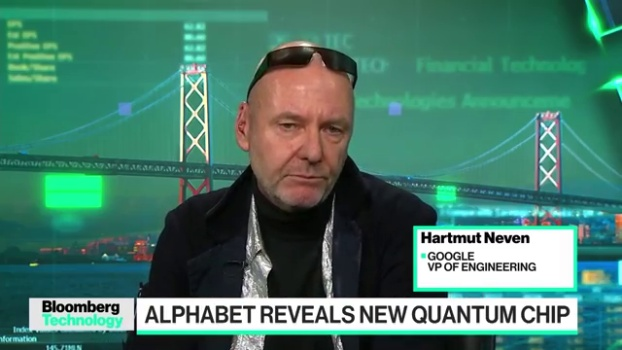
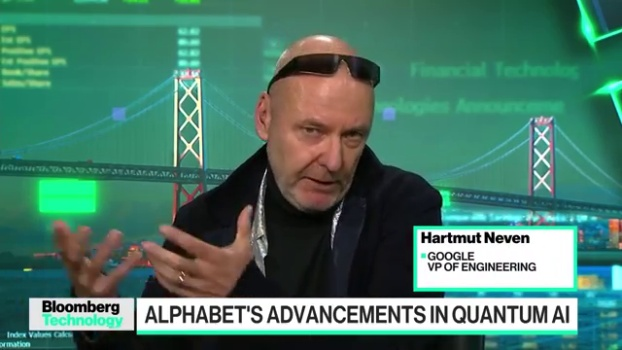
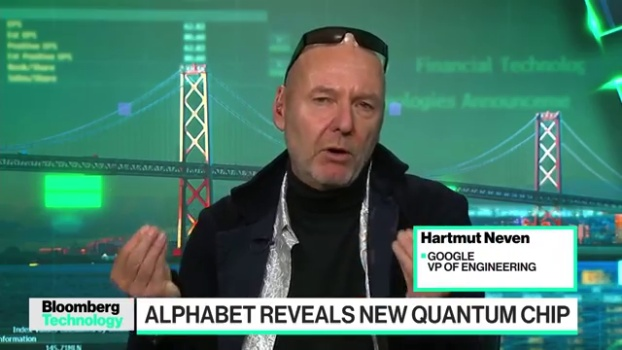
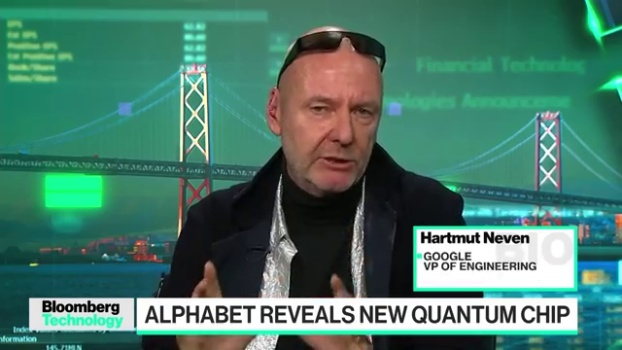
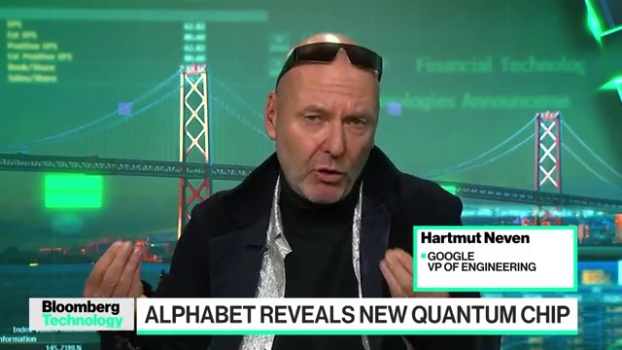

In [173]:
def handle_query_with_history(query, chat_history=[], top_k=5):
    """
    Handles user queries with chat history, retrieves relevant documents, and processes metadata.
    """
    # Use the existing vector_db and id_to_metadata

    query_embedding = create_embeddings(text=query+'man with black glasses')
    relevant_indices = search_vector_db(vector_db, query_embedding, top_k=top_k)
    relevant_metadata = [id_to_metadata.get(index) for index in relevant_indices if id_to_metadata.get(index)]

    content=[]


    # Prepare the LLM query with chat history and metadata
    content.append({"type": "text", "text": f"Query: {query }\n\nChatHistory:\n "})
    # for turn in chat_history:
    #     llm_query += f"User: {turn[0]}\nAI: {turn[1]}\n"
    content.append({"type": "text", "text":"\nRelevant Documents:\n"})
    for i, metadata in enumerate(relevant_metadata):
        llm_query = ""
        llm_query += f"---Document {i+1}---\n"
        llm_query += f"Transcript: {metadata['transcript']}\n"
        content.append({"type": "text", "text":llm_query})
        base64_image = encode_image(metadata['extracted_frame_path'])
        content.append({"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}})
    print(content)
    # Invoke the LLM with the query and history
    response = llm.invoke([HumanMessage(content=content)])

    # Update chat history
    chat_history.append((query, response.content))

    return response.content, chat_history

def handle_query_with_persona(vector_store, query, persona, chat_history=[], top_k=5):
    """
    Handles user queries with a specified persona.
    """
    # Construct a prompt incorporating the persona
    prompt = f"You are now {persona}.  Respond to the following query: {query}"

    # Use the modified prompt with handle_query_with_history
    return handle_query_with_history( prompt, chat_history, top_k)
# Example Usage
chat_history = []
query = " Who is the hartmut neven"
persona = " You are a helpful assistant in a video-based chat application. Your job is to analyze the user's query, use the provided transcript and frames, and give an accurate and detailed response. in a user friendly manner without giving context about the internal detail you got"

answer, chat_history = handle_query_with_persona(vector_db,query, persona = persona,chat_history=chat_history)
print(f"Answer: {answer}")

